## Import necessary Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import date, datetime, timedelta

import os

## Object of Portfolios and benchmarking ETF

In [2]:
class EquitiesPF():

    def __init__(self, benchmark, symbollist, etf_path, symbol_path, startdate='2011-01-03', enddate='2018-12-31'):
        self.benchmark = benchmark     # Benchmark equity index (e.g. S&P 500 ETF such as SPY or VOO)
        self.symbollist = symbollist   # List of all equity symbols to be considered
        self.etf_path = self.join_path(etf_path)   # ETF data path
        self.symbol_path = self.join_path(symbol_path)  
        self.startdate = startdate     # Start of buy-and-hold period
        self.enddate = enddate         # End of buy-and-hold period
        self.data_dict = self.get_data_dict()   # Dictionary with each equity symbol corresponding to its historical data
        
    def join_path(self, *args):
        """Convenient function to trace local data folders."""
        yahoo_path = os.path.join('D:\\', 'Trading', 'Data', 'eod_yahoofinance')
        return os.path.join(yahoo_path, *args)
    
    def get_data_dict(self):
        """Create dictionary matching each symbol with historical prices dataframe."""
        price_dict = dict()
        # Set the data columns of each Yahoo Finance Dataframe
        columns = ['Open', 'High', 'Low', 'Close', 'Volume']
        
        # Collect the index ETF data into the data dict
        df_index = pd.read_csv(self.join_path(self.etf_path, self.benchmark + '.csv'), header=0, index_col='date', parse_dates=True)
        df_index = df_index.loc[self.startdate:self.enddate]
        df_index.columns = columns
        price_dict[self.benchmark] = df_index
        
        # Collect each symbol data into the data dict
        for symbol in self.symbollist:
            df = pd.read_csv(self.join_path(self.symbol_path, symbol + '.csv'), header=0, index_col='date', parse_dates=True)
            df.fillna(method='ffill', inplace=True)           
            df = df.loc[self.startdate:self.enddate]
            df.columns = columns
            price_dict[symbol] = df
        
        return price_dict
    
    def get_normed_price(self):
        """Set the price of each asset to be 1.00 at startdate and normalize the historical prices."""
        df_normed_index = self.data_dict[self.benchmark].loc[:, ['Close']] / self.data_dict[self.benchmark].loc[:, 'Close'][0]
        df_normed_index.columns = [self.benchmark]
        df_normed_symbols = pd.DataFrame(columns=self.symbollist)
        for symbol in self.symbollist:
            df_normed_symbols[symbol] = self.data_dict[symbol].loc[:, 'Close'] / self.data_dict[symbol].loc[:, 'Close'][0]
        
        return df_normed_index, df_normed_symbols
    
    def pf_weight(self, weight):
        """Get the daily percentage return of each symbol, the portfolio and the benchmark index ETF."""
        assert weight.min() >= 0, 'Input weight vector has negative weight!'
        assert len(weight) == len(self.symbollist), 'Length of weight vector does NOT match!'
        df_normed_index, df_normed_pf = self.get_normed_price()
        df_normed_pf['Portfolio'] = df_normed_pf.mul(weight, axis=1).sum(axis=1)
        df_normed_pf['Benchmark'] = df_normed_index

        # Percentage return for each symbol and the weighted portfolio
        df_pct_pf = df_normed_pf.pct_change()

        return df_normed_pf, df_pct_pf
    
    def pf_cov(self, weight):
        """Compute the asset corrleation & covariance and also with the portfolio and benchmark."""
        df_normed_df, df_pct_pf = self.pf_weight(weight)
        cov_symbols = df_pct_pf.cov()
        corr_symbols = df_pct_pf.corr()
        return cov_symbols, corr_symbols
    
    def pf_perform_KPI(self, weight):
        """Get the performance KPI from the time series of percentage or logarithmic daily return."""
        df_normed_pf, df_pct_pf = self.pf_weight(weight)
        cov_symbols, corr_symbols = self.pf_cov(weight)
        df_log_pf = np.log(df_pct_pf.add(1))
        df_kpi = pd.DataFrame(columns=df_log_pf.columns)
        row_label = pd.Series(['mean_return', 'sigma', 'sharpe_ratio', 'MDD', 'beta'])
        for asset in df_kpi.columns:
            df_kpi[asset] = [df_log_pf[asset].mean(),   # Mean daily log return 
                             df_log_pf[asset].std(),    # SD of daily log return
                             df_log_pf[asset].mean() / df_log_pf[asset].std() * np.sqrt(252),   # Sharpe Ratio
                             (df_normed_pf[asset] / df_normed_pf[asset].cummax()).min() - 1,       # MDD
                             cov_symbols.loc[asset, 'Benchmark'] / cov_symbols.loc['Benchmark', 'Benchmark'] ]
        df_kpi.set_index(row_label, inplace=True)
                
        return df_kpi

### Object of Sector ETF Portfolio

In [3]:
# US Sector ETF list 

sectorlist = ['XLB', # Building Materials Sector ETF
              'XLE', # Energy Sector ETF
              'XLF', # Financial Sector ETF
              'XLI', # Industrial Sector ETF
              'XLK', # Technology Sector ETF
              'XLP', # Consumer Staples Sector ETF
              'XLU', # Utilities Sector ETF
              'XLV', # Health Care ETF
              'XLY', # Consumer Discretionary ETF
              'VNQ', # Real Estate Index Fund ETF
              'TLT', # 20-Year Treasury Bond ETF
              'GLD'  # Gold ETF
             ]
              
benchmark = 'SPY'         # S&P 500 ETF
etf_path = 'ETF_adjusted' # Use dividend-adjusted data, assuming dividend reinvestment

USetf = EquitiesPF(benchmark, sectorlist, etf_path, etf_path) # Object of ETF portfolios

# The normed index of each ETF (with prices on 2-Jan-2011 set as 1.0000)
df_spy, df_sector = USetf.get_normed_price()
df_sector.tail(10)



,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,VNQ,TLT,GLD
date,,,,,,,,,,,,
2018-12-17,1.528317,1.062240,2.736184,2.199751,2.830027,2.232322,2.318966,3.120086,2.949398,1.886026,1.592284,0.854130
2018-12-18,1.536801,1.037148,2.725923,2.210759,2.852417,2.205906,2.303363,3.092890,2.972466,1.905465,1.601820,0.856159
2018-12-19,1.515894,1.024950,2.691721,2.169065,2.795995,2.184522,2.299568,3.052453,2.913614,1.884550,1.622981,0.850942
2018-12-20,1.495594,0.996547,2.667780,2.129373,2.745843,2.145528,2.298303,3.009511,2.848256,1.856253,1.617088,0.864058
2018-12-21,1.482144,0.986873,2.614435,2.089167,2.662417,2.123271,2.288478,2.972126,2.783710,1.830418,1.616821,0.860290
2018-12-24,1.443718,0.946948,2.559370,2.025066,2.591360,2.061918,2.192788,2.900950,2.730862,1.765212,1.624856,0.869710
2018-12-26,1.508372,1.005869,2.675236,2.119372,2.747866,2.119463,2.222558,3.027485,2.892671,1.824266,1.607445,0.867101
2018-12-27,1.536124,1.011145,2.707357,2.145885,2.767655,2.139774,2.241271,3.060916,2.908110,1.824020,1.607713,0.873696
2018-12-28,1.527890,1.003406,2.706210,2.140180,2.761359,2.139774,2.246800,3.064511,2.908407,1.829925,1.621240,0.877246


-  From last row, over past 8 years Health Care, Techonology, Consumer Discretionary are three best sectors for returns

In [4]:
# Equal Weight Portfolio
eqweight = np.repeat(1/len(sectorlist), len(sectorlist))
df_pct_sector = USetf.pf_weight(eqweight)

# Buy-and-hold Performance over past 8 years
df_kpi = USetf.pf_perform_KPI(eqweight)
df_kpi

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,VNQ,TLT,GLD,Portfolio,Benchmark
mean_return,0.000215,0.000004,0.000500,0.000383,0.000510,0.000380,0.000403,0.000564,0.000536,0.000302,0.000242,-0.000064,0.000365,0.000417
sigma,0.011825,0.013706,0.013608,0.010601,0.010501,0.007487,0.008835,0.009479,0.010028,0.010704,0.008595,0.009963,0.007178,0.009158
sharpe_ratio,0.288545,0.004979,0.583124,0.574013,0.770610,0.806419,0.724801,0.944783,0.848812,0.447631,0.447266,-0.102523,0.808118,0.722643
MDD,-0.294984,-0.467452,-0.336773,-0.258383,-0.237849,-0.161044,-0.156900,-0.173344,-0.213715,-0.226337,-0.206588,-0.455550,-0.158385,-0.193489
beta,1.136864,1.171984,1.194004,1.080013,1.051917,0.631202,0.485336,0.894624,1.011518,0.822857,-0.446437,-0.034328,0.759915,1.000000


### Correlation & Covariance of returns

- Notice that TLT & GLD has negative beta and hence negative correlation with SPY 
- Utilities Sector has least beta among all sector ETFs

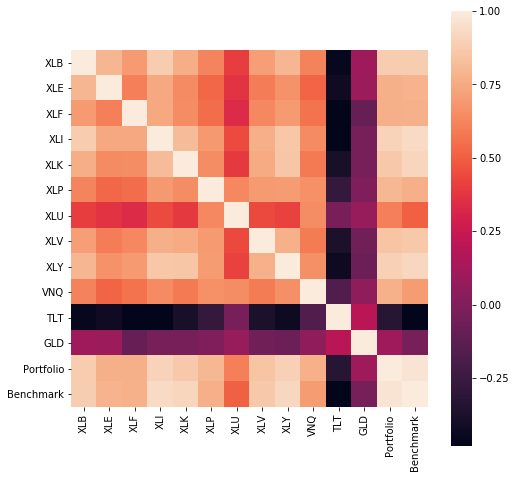

In [5]:
import seaborn as sns

cov_pf, corr_pf = USetf.pf_cov(eqweight)

# Using Heatmap to illustrate corrleation matrix 
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(corr_pf, square=True, ax=ax)

## Object of Portfolio Optimizer 

- Use uniform distribution to generate weights 
- Adopt "Max entropy principle" based on assumption that we have no significant prior knowledge 

In [33]:
class PFOptimizer():
    
    def __init__(self, symbollist, normed_pf, normed_index, rand_size=2500, startdate='2011-01-03', enddate='2018-12-31'):
        self.symbollist = symbollist
        self.startdate = startdate
        self.enddate = enddate
        self.normed_pf = normed_pf       # The normed price of each equity symbol
        self.normed_index = normed_index # The normed price of benchmark index 
        self.rand_size = rand_size       # Number of simulations
        self.rand_weight = self.get_random_weight() # Dataframe consisting of each random weight
        
    def get_random_weight(self):
        """Generate random weights from uniform distribution and store them into a dataframe."""
        df_weight = pd.DataFrame(columns=self.symbollist)
        for symbol in self.symbollist:
            df_weight[symbol] = np.random.uniform(size=self.rand_size)
        df_weight = df_weight.div(df_weight.sum(axis=1), axis=0)
        
        return df_weight
        
    def randweight_kpi(self, normed_pf, normed_index):
        """Compute KPI's such as mean return, sigma for each randomized portfilio."""
        # Create empty dataframe with the desired KPI as column names
        kpi_columns = ['mean%', 'sigma%', 'sharpe', 'beta']
        df_kpi = pd.DataFrame(columns=kpi_columns)
        index_return = np.log(normed_index.pct_change() + 1)
        
        # For loop to compute the KPI
        for num in range(self.rand_size):
            weight = self.rand_weight.iloc[num, :]
            df_portfolio = normed_pf.mul(weight, axis=1).sum(axis=1)
            log_return = np.log(df_portfolio.pct_change() + 1)
            
            log_mean = 100 * log_return.mean() * 252                 # Average daily log return
            log_sd = 100 * log_return.std() * np.sqrt(252)           # Average daily SD
            sharpe = log_mean / log_sd                               # Sharpe Ratio
            
            # Calcuation of beta (ratio of covariance over benchmark's variance)
            cov_random = pd.concat([pd.DataFrame(log_return, columns=['portfolio']), index_return], axis=1).cov()
            beta = cov_random.iloc[0, 1] / cov_random.iloc[1, 1]    # beta
            df_kpi = df_kpi.append({'mean%': log_mean, 'sigma%': log_sd, 'sharpe': sharpe, 'beta': beta}, 
                                   ignore_index=True)
            
        df_kpi = pd.concat([self.rand_weight, df_kpi], axis=1)    
        
        return df_kpi
            
    def train_test_split(self, train_end):
        """Split the dataset into training set and test set, with normed prices in each of two datasets."""
        
        # Split the normed_pf and normed_index dataframes into two halves
        train_pf = self.normed_pf.loc[self.startdate:train_end]
        train_index = self.normed_index.loc[self.startdate:train_end]
        test_pf = self.normed_pf.loc[train_end:]
        test_index = self.normed_index.loc[train_end:]
        
        # Normalize the test datasets
        test_pf = test_pf / test_pf.iloc[0, :]
        test_index = test_index / test_index.iloc[0, :]      
        
        # KPI dataframes for training datasets & test datasets
        train_kpi = self.randweight_kpi(train_pf, train_index)
        test_kpi = self.randweight_kpi(test_pf, test_index)
        
        return train_kpi, test_kpi
    
    

## Simulate 2500 portfolios

In [34]:
# Start time count for simulations
from time import time
start_time = time()

# Initialize ETF portfolio Optimizer
size = 2500
Etfopt = PFOptimizer(sectorlist, df_sector, df_spy, rand_size=size)

# Random Weights
df_weight = Etfopt.rand_weight  

# KPI corresponding to each portfolio
df_kpi = Etfopt.randweight_kpi(df_sector, df_spy)

print('Mean Sharpe: ', df_kpi['sharpe'].mean())
print('Max Sharpe: ',  df_kpi['sharpe'].max())
print('Mean CAGR: ', df_kpi['mean%'].mean() * 252)
print('Max CAGR: ', df_kpi['mean%'].max() * 252)
print('Mean Sigma: ' , df_kpi['sigma%'].mean() * np.sqrt(252))
print('Min Sigma: ' , df_kpi['sigma%'].min() * np.sqrt(252))
print('Average beta: ', df_kpi['beta'].mean())

# Check time elapsed
print('\nTime elapsed: ', time() - start_time)

Mean Sharpe:  0.8025214163822397
Max Sharpe:  1.1305816968002282
Mean CAGR:  2320.8726500199264
Max CAGR:  2854.8688218715824
Mean Sigma:  183.1494028448088
Min Sigma:  132.8343297472535
Average beta:  0.7592175876538033

Time elapsed:  9.408801794052124


### Sorting with Sharpe ratios, mean return & volatility

In [35]:
# Portfolio with max sharpe
maxsharpe_row = df_kpi['sharpe'].idxmax()
maxsharpe_df = df_weight.iloc[[maxsharpe_row], :]

# Portfolio with max return
maxreturn_row = df_kpi['mean%'].idxmax()
maxreturn_df = df_weight.iloc[[maxreturn_row], :]

# Portfolio with min volatility
minvol_row = df_kpi['sigma%'].idxmin()
minvol_df = df_weight.iloc[[minvol_row], :]

# Joining the three objectives
df_optpf = pd.concat([maxsharpe_df, maxreturn_df, minvol_df], axis=0)
df_optpf.index = ['max_sharpe', 'max_return', 'min_vol']
df_optpf

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,VNQ,TLT,GLD
max_sharpe,0.011624,0.002317,0.052306,0.032634,0.039684,0.176320,0.197880,0.113469,0.055591,0.012711,0.206015,0.099448
max_return,0.075274,0.042220,0.120377,0.037921,0.172940,0.092517,0.026500,0.180529,0.166734,0.031254,0.004741,0.048994
min_vol,0.006316,0.068758,0.027426,0.070385,0.005834,0.256744,0.068822,0.101767,0.059288,0.002534,0.197924,0.134201


### Average weights of top 25 Sharpe-ratio portfolios (with pie chart)

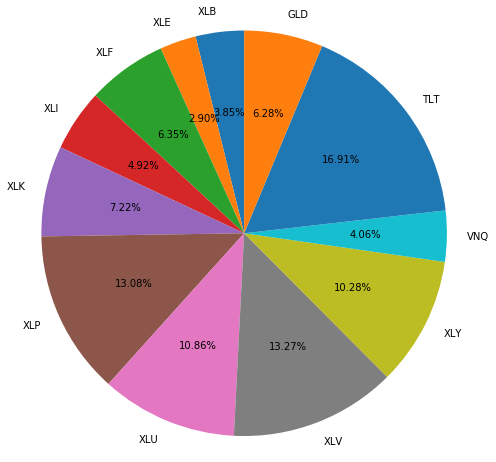

In [36]:
# Sort the portfolios by Sharpe ratio (descending order)
df_sort_sharpe = df_kpi.sort_values(['sharpe', 'mean%'], ascending=False)
df_sort_sharpe.reset_index(inplace=True)
df_sort_sharpe.drop('index', axis=1, inplace=True)

# Average weights & Sharpe ratio of the top 1% portfolios
top_sharpe = pd.DataFrame(df_sort_sharpe.head(size//100).mean()).transpose()

# Piechart labels by the ETF symbol list
labels = USetf.symbollist
pct = top_sharpe.loc[0, USetf.symbollist]

# Constructing Pie Chart
fig, ax = plt.subplots(figsize=(8,8))
ax.pie(pct, labels=labels, autopct='%1.2f%%', shadow=False, startangle=90)
ax.axis('equal')
plt.show()


In [40]:
# Average KPI for the top 25 Sharpe-ratio Portfolios

top_sharpe.loc[:, ['mean%', 'sigma%', 'sharpe', 'beta']]

,mean%,sigma%,sharpe,beta
0,9.951084,9.763428,1.020324,0.613161


- Top 25 Sharpe Porfolio on average puts heaviest weights on the following 3 sectors:
    - Treasury Bonds (ETF)
    - Health Care 
    - Consumer Staples 

***

- Top 25 Sharpe Portfolio has an average of 
    - 9.95% annual compound return
    - 9.76% annualized volatility
    - About Sharpe ratio 1
    - beta 0.61 significantly lower than 1

### Average weights of top 25 Return portfolios

-  Expect heavier weights of best-growth sectors such as health care and technologies

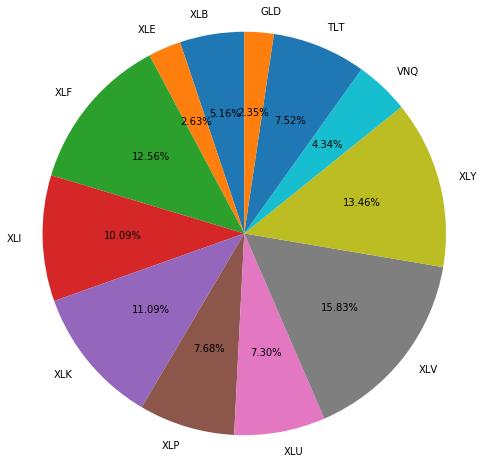

In [38]:
# Average weights & Sharpe ratio of the top 1% return portfolios
df_sort_return = df_kpi.sort_values(['mean%', 'sharpe'], ascending=False)
df_sort_return.reset_index(inplace=True)
df_sort_return.drop('index', axis=1, inplace=True)

labels = USetf.symbollist
pct = top_return.loc[0, USetf.symbollist]

fig, ax = plt.subplots(figsize=(8,8))
ax.pie(pct, labels=labels, autopct='%1.2f%%', shadow=False, startangle=90)
ax.axis('equal')

plt.show()

In [39]:
top_return = pd.DataFrame(df_sort_return.head(size//100).mean()).transpose()
top_return.loc[:, ['mean%', 'sigma%', 'sharpe', 'beta']]


,mean%,sigma%,sharpe,beta
0,11.015664,12.516382,0.885631,0.836253


- Top 25 Return Porfolio on average puts heaviest weights on following sectors:
    - Health Care
    - Consumer Discretionary
    - Financial
    
***

- Top 25 Return Portfolio has an average of 
    - Over 11% annual compound return
    - Over 12.5% annualized volatility
    - About Sharpe ratio 0.89
    - beta 0.84 and more volatile and  more correlated to S&P 500



### Average weights of top 25 low-volatility portfolios

-  Expect heavier weights of risk-off assets like TLT, GLD

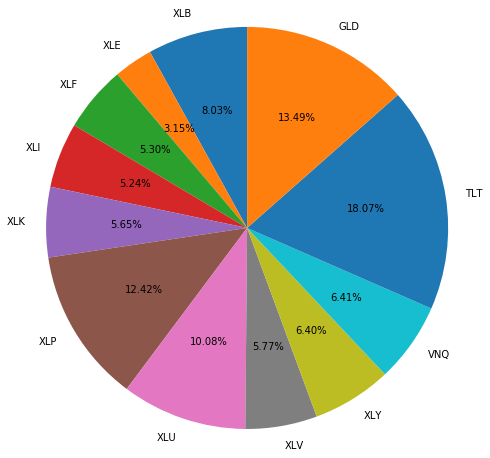

In [43]:
# Average weights & Sharpe ratio of the bottom 1% volatility portfolios

df_sort_sigma = df_kpi.sort_values(['sigma%'], ascending=True)
df_sort_sigma.reset_index(inplace=True)
df_sort_sigma.drop('index', axis=1, inplace=True)

min_vol = pd.DataFrame(df_sort_sigma.head(size//100).mean()).transpose()
pct = min_vol.loc[0, USetf.symbollist]

fig, ax = plt.subplots(figsize=(8,8))
ax.pie(pct, labels=labels, autopct='%1.2f%%', shadow=False, startangle=90)
ax.axis('equal')

plt.show()

In [44]:
# Average KPI for the top 25 low-vol Portfolios

min_vol.loc[:, ['mean%', 'sigma%', 'sharpe', 'beta']]

,mean%,sigma%,sharpe,beta
0,8.435413,9.036497,0.93478,0.537087


- Top 25 low-vol Porfolio on average puts heaviest weights on following sectors:
    - Treasuries
    - Gold
    - Consumer Staples
    
***

- Top 25 Return Portfolio has an average of 
    - 8.4% annual compound return
    - About 9% annualized volatility
    - Sharpe ratio 0.93 slightly higher than top 25 return
    - beta only 0.53 

### Scatter Plot & Optimal Portfolios

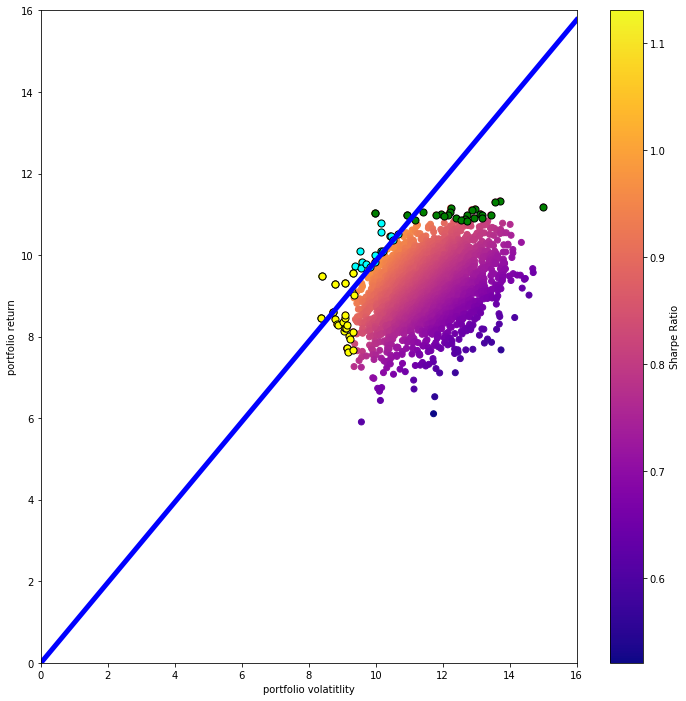

In [69]:
# Scatter plot of all (sigma, return)-tuple of the 10000 portfolios 
plt.figure(figsize=(12,12))
fig = plt.scatter(df_sort_sharpe['sigma%'], df_sort_sharpe['mean%'], c=df_sort_sharpe['sharpe'], cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('portfolio volatitlity')
plt.ylabel('portfolio return')

# Add cyan dots for top 25 Sharpe ratio
top1 = plt.scatter(df_sort_sharpe.head(size//100)['sigma%'], df_sort_sharpe.head(size//100)['mean%'], c='cyan', s=50, edgecolors='black')

# Add green dots for top 25 Return
top2 = plt.scatter(df_sort_return.head(size//100)['sigma%'], df_sort_return.head(size//100)['mean%'], c='green', s=50, edgecolors='black')

# Add yellow dots for top 25 low-vol
top3 = plt.scatter(df_sort_sigma.head(size//100)['sigma%'], df_sort_sigma.head(size//100)['mean%'], c='yellow', s=50, edgecolors='black')

# Add straight line of optimal portfolios
xline = np.linspace(0, 16.0, 500)
yline = df_sort_sharpe['sharpe'][24] * xline
plt.plot(xline, yline, 'b-', linewidth=5)

# Set annualized return range from 0 to 16%
plt.ylim(ymin=0)
plt.ylim(ymax=16)

# Set sigma range from 0 to 16%
plt.xlim(xmin=0)
plt.xlim(xmax=16)
plt.show()

- However the above diagram is NOT a reasonable modelling of forward testing
- Train-test-split is necessary

## Train-test-split on asset weights

- Split the dataset into two equal halves
- Find the top 1% sharpe-ratio portfolios on training set (2011-2014)
- Verify the respective (sigma, return)-tuple on test set (2015-2018)


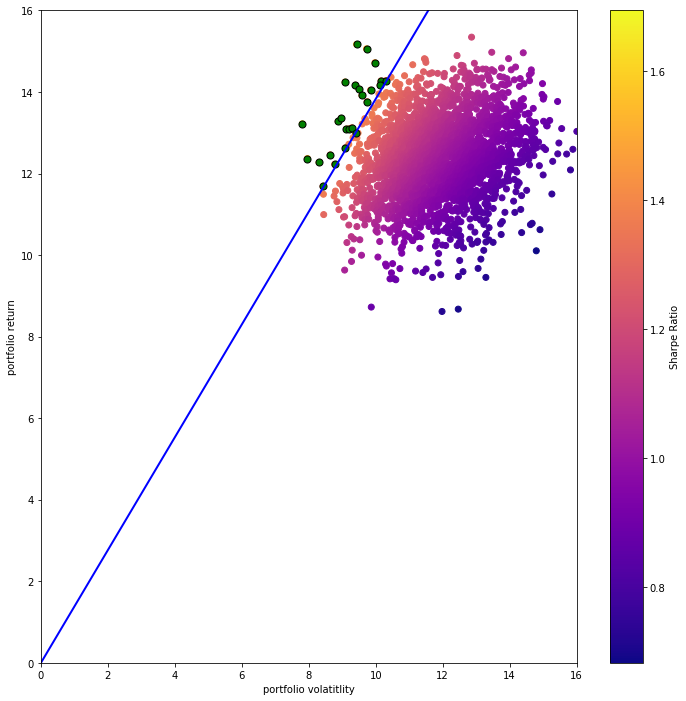

In [74]:
# Split the dataset by the timestamp 2014-12-31
# train_KPI:  2011-2014
# test_KPI:   2015-2018
train_kpi, test_kpi = Etfopt.train_test_split('2014-12-31')

# Sort with descending Sharpe ratio and scatter plots 
train_sort_sharpe = train_kpi.sort_values(['sharpe', 'mean%'], ascending=False)
train_sort_sharpe.reset_index(inplace=True)

plt.figure(figsize=(12,12))
fig = plt.scatter(train_sort_sharpe['sigma%'], train_sort_sharpe['mean%'], c=train_sort_sharpe['sharpe'], cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('portfolio volatitlity')
plt.ylabel('portfolio return')

# Add red dots for top 1% Sharpe ratio
top = plt.scatter(train_sort_sharpe.head(size//100)['sigma%'], train_sort_sharpe.head(size//100)['mean%'], c='green', s=50, edgecolors='black')

# Add straight line of optimal portfolio
xline = np.linspace(0, 16.0, 500)
yline = train_sort_sharpe['sharpe'][size//100] * xline
plt.plot(xline, yline, 'b-', linewidth=2)

# Set annualized return range from 0 to 16%
plt.ylim(ymin=0)
plt.ylim(ymax=16)

# Set sigma range from 0 to 16%
plt.xlim(xmin=0)
plt.xlim(xmax=16)
plt.show()


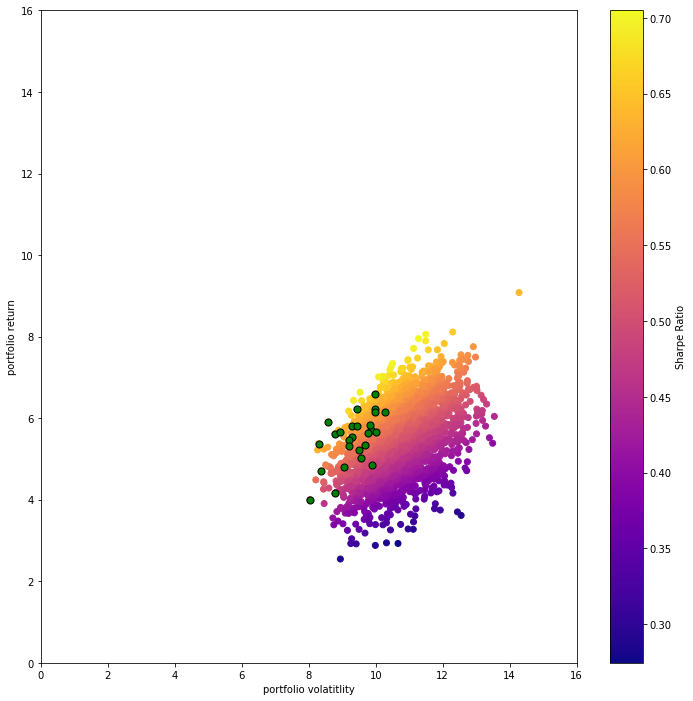

In [73]:
# Apply the top 1% sharpe in training set to test set 

top_index = train_sort_sharpe.loc[0:size//100, 'index']

plt.figure(figsize=(12,12))
fig = plt.scatter(test_kpi['sigma%'], test_kpi['mean%'], c=test_kpi['sharpe'], cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('portfolio volatitlity')
plt.ylabel('portfolio return')

# Add red dots for top 1% Sharpe ratio
top = plt.scatter(test_kpi.loc[top_index, 'sigma%'], test_kpi.loc[top_index, 'mean%'], c='green', s=50, edgecolors='black')

# Set annualized return range from 0 to 16%
plt.ylim(ymin=0)
plt.ylim(ymax=16)

# Set sigma range from 0 to 16%
plt.xlim(xmin=0)
plt.xlim(xmax=16)
plt.show()

### KPI for training set and test set

- Expect top 25 Sharpe in training set performs worse in test set
- Expect lower Sharpe in test set versus training set due to 2015 & 2018 huge correction 

In [75]:
# KPI for training set


top_train.loc[:, ['mean%', 'sigma%', 'sharpe', 'beta']]

,mean%,sigma%,sharpe,beta
0,13.507829,9.229123,1.46595,0.542999


In [76]:
# Mean Performance in test set

top_apply_test = pd.DataFrame(test_kpi.loc[top_index].mean()).transpose()
top_apply_test.loc[:, ['mean%', 'sigma%', 'sharpe', 'beta']]

,mean%,sigma%,sharpe,beta
0,5.491528,9.34432,0.587544,0.60595


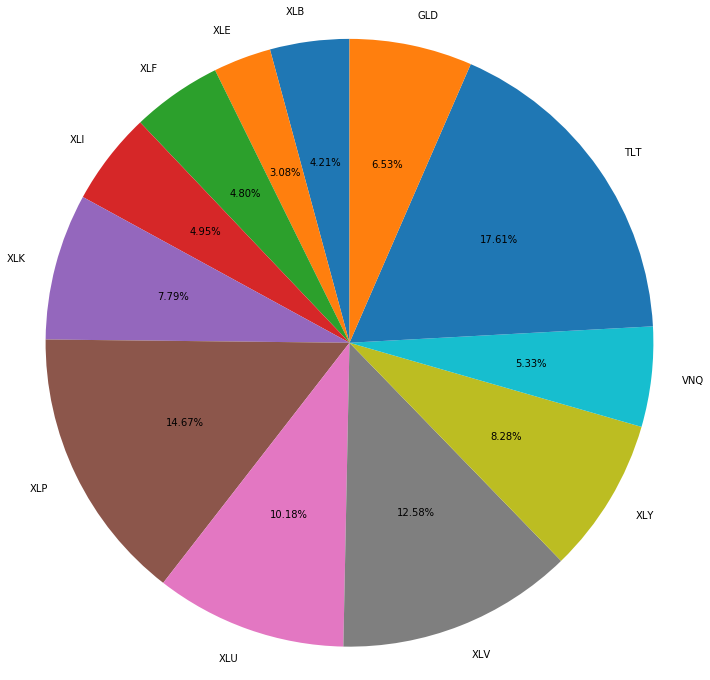

In [77]:
# Mean allocation for top 1% sharpe in training set

sector_list = USetf.symbollist

top_train = pd.DataFrame(train_sort_sharpe.head(size//100).mean()).transpose()
top_train_allocate = top_train.loc[0, sector_list]

fig, ax = plt.subplots(figsize=(12,12))
ax.pie(top_train_allocate, labels=sector_list, autopct='%1.2f%%', shadow=False, startangle=90)
ax.axis('equal')

plt.show()
